### 백테스팅

In [719]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob

### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def calculate_mdd(cumulative_returns):
    """
    Maximum Drawdown (MDD) 계산 함수
    :param cumulative_returns: 누적 수익률 (1 + 전략 수익률).cumprod() 형태의 데이터
    :return: MDD (최대 낙폭)
    """
    peak = np.maximum.accumulate(cumulative_returns)  # 최고점 누적 기록
    drawdown = (cumulative_returns - peak) / peak  # 각 시점의 손실 비율
    mdd = drawdown.min()  # 최대 손실율 (음수 값)
    return mdd


def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])
    return df[(df['date']>=start) & (df['date']<=end)]




# Sharpe Ratio 계산 함수
def calculate_sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(252)

In [720]:
target_list = glob.glob('./data/target/*.csv')
target_list

['./data/target\\big_transaction_address_transaction_10000_target_little_money_receive_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_little_money_send_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_loop_receive_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_loop_send_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_multi_sender_receive_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_multi_sender_send_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_no_loop_receive_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_no_loop_send_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_one_sender_receive_250125.csv',
 './data/target\\big_transaction_address_transaction_10000_target_one_sender_send_250125.csv',
 './data/target\\big_transaction_address_tran

In [721]:
# # test 데이터 읽기
# test_df = pd.read_csv("./data/test/test_df.csv")
# test_df.set_index('date', inplace=True)

# # price coin market cap으로
# price_df = pd.read_csv("./data/price/bitcoin_price_coin_market_cap.csv")
# price_df = price_df.set_index('date')


# test_df['close'] = price_df['close']
# test_df['open'] = price_df['open']
# test_df['high'] = price_df['high']
# test_df['low'] = price_df['low']
# test_df['volume'] = price_df['volume']

# test_df['returns'] = test_df['close'].pct_change()
# test_df['abs_returns'] = test_df['returns'].abs()

In [722]:
# test 데이터 읽기
test_df = pd.read_csv("./data/test/test_df.csv")
test_df.set_index('date', inplace=True)

# target 데이터 읽기
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']
target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])



### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'

event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']


##### 전처리 관련
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())


# test_df = test_df[test_df.index>='2024-01-01']
test_df = test_df[(test_df.index>='2017-01-01')&(test_df.index<='2024-12-31')]

C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\768101534.py:50: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


### 백테스팅용 파생변수 생성 (Trading Flag...)
Transaction amount를 이용해 Trading Flag 생성

In [723]:
# # check test df 날짜 인덱싱
# check_test_df = test_df.copy()
# check_test_df = check_test_df[check_test_df.index>='2023-01-01']

# ### test_df에 target_df 데이터 적용
# check_test_df['transaction_count'] = target_df['transaction_count']
# check_test_df['transaction_amount'] = target_df['transaction_amount']
# check_test_df['transaction_flag'] = target_df['transaction_flag']
# check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']

# # trading flag 생성
# check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).fillna(check_test_df.mean())
# threshold = 0
# check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_returns'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else (-1 if x == np.inf else 0)))
# check_test_df['transaction_amount_trading_reversion'] = check_test_df['transaction_amount_returns'].apply(lambda x: -1 if x > 0 else (1 if x < -0 else 0))

# # 지연 수익률 계산, carrying 수익률 
# check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
# check_test_df['returns_after_1day'] = check_test_df['returns'].shift(-1).fillna(check_test_df.mean())
# check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
# check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
# check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
# check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

# ## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
# check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
# check_test_df = check_test_df.fillna(check_test_df.mean())


# # Scaling, Weighted Return 파생변수 생성
# check_test_df['scaled_transaction_amount'] = (check_test_df['transaction_amount']-check_test_df['transaction_amount'].min()) / (check_test_df['transaction_amount'].max()-check_test_df['transaction_amount'].min())
# check_test_df['transaction_amount_weight_returns'] = check_test_df['scaled_transaction_amount'] * check_test_df['returns']
# check_test_df['lag_reversion_returns'] = check_test_df['transaction_amount_trading_reversion'] * check_test_df['returns_after_1day']

# # Trading 결과 확인하기 위해 adjusted_returns 생성
# check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]

# check_test_df['adjusted_returns'] = check_test_df['adjusted_returns'].astype(float)
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# # trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# # check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'].apply(lambda x: -x) # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# ####################
# # trading 없이 비교
# plt.plot((check_test_df.returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.returns.mean()/check_test_df.returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

# # 2일 뒤 returns (2 day after returns)
# plt.plot((check_test_df.adjusted_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.adjusted_returns.mean()/check_test_df.adjusted_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.adjusted_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

### Target Amount Quantile 나눠서 백테스팅

C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\2252731830.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01296866 -0.01720142  0.0059761  ...  0.00176095  0.00176095
  0.00176095]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지


Sharpe Ratio (Carrying):  0.6950355040109919
Cumulative Returns (Carrying):  15.377545231397958
MDD (Carrying):  -0.87170027527068
Sharpe Ratio (With Trading Flag):  0.864515713845338
Cumulative Returns (With Trading Flag):  50.433718396974
MDD (With Trading Flag):  -0.7662925431645935


C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\2252731830.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Carrying): ', (check_test_df.returns_after_3day + 1).cumprod()[-1])
C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\2252731830.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (With Trading Flag): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])


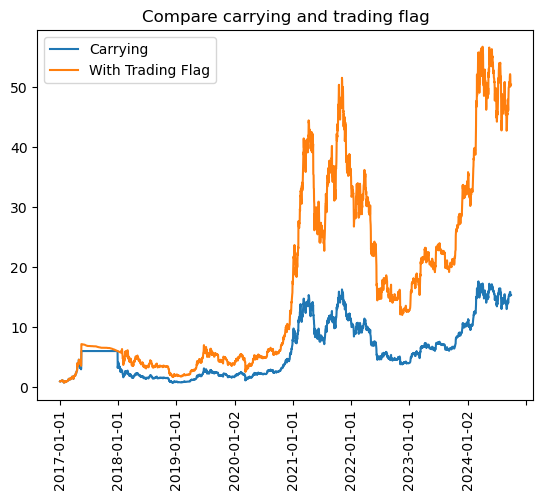

In [724]:
# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[check_test_df.index>='2017-01-01']

### test_df에 target_df 데이터 적용
check_test_df['transaction_count'] = target_df['transaction_count']
check_test_df['transaction_amount'] = target_df['transaction_amount']
check_test_df['transaction_flag'] = target_df['transaction_flag']
check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).shift(-1).fillna(check_test_df.mean())

# threshold = 0.1
# # 거래량 상위 5% 임계값 설정
# upper_threshold = check_test_df['transaction_amount'].quantile(1-threshold)
# lower_threshold = check_test_df['transaction_amount'].quantile(threshold)
# check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount'].apply(lambda x: 1 if x >= upper_threshold else (-1 if x <= lower_threshold else (-1 if x == np.inf else 0)))

threshold = check_test_df['transaction_amount_usd'].quantile(0.95)
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_usd'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_1day'] = check_test_df['returns'].shift(-1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'].apply(lambda x: -x) # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지
trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002

# # trading 없이 비교
# plt.plot((check_test_df.returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.returns.mean()/check_test_df.returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

# # 2일 뒤 returns (2 day after returns)
# plt.plot((check_test_df.adjusted_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.adjusted_returns.mean()/check_test_df.adjusted_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.adjusted_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()  # 현재 그래프의 X축 가져오기
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
# plt.show()

plt.title('Compare carrying and trading flag')
plt.plot((check_test_df.returns_after_3day + 1).cumprod(), label='Carrying')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='With Trading Flag')

print('Sharpe Ratio (Carrying): ', check_test_df.returns_after_3day.mean() / check_test_df.returns_after_3day.std() * np.sqrt(252))
print('Cumulative Returns (Carrying): ', (check_test_df.returns_after_3day + 1).cumprod()[-1])
print('MDD (Carrying): ', calculate_mdd((check_test_df.returns_after_3day + 1).cumprod()))

print('Sharpe Ratio (With Trading Flag): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Cumulative Returns (With Trading Flag): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (With Trading Flag): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()



benchmark_sharpe = check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252)


C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\464697375.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.07123732  0.03893996 -0.00737    -0.00856284  0.00406184  0.02823914
  0.02318182 -0.00181    -0.01313975  0.01416279  0.04385639 -0.00952033
  0.00449451 -0.01193866  0.09568582 -0.02283183  0.0450852  -0.00316064
  0.01690076  0.01527228 -0.0001692  -0.02356923  0.01048653 -0.0071452
  0.02397454  0.01456757 -0.01728359  0.03201767  0.00914414]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day']
C:\Users\slaye\AppData\Local\Temp\ipykernel_14572\464697375.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00402697  0.07123732  0.03893996 -0.00737    -0.00856284 -0.0074

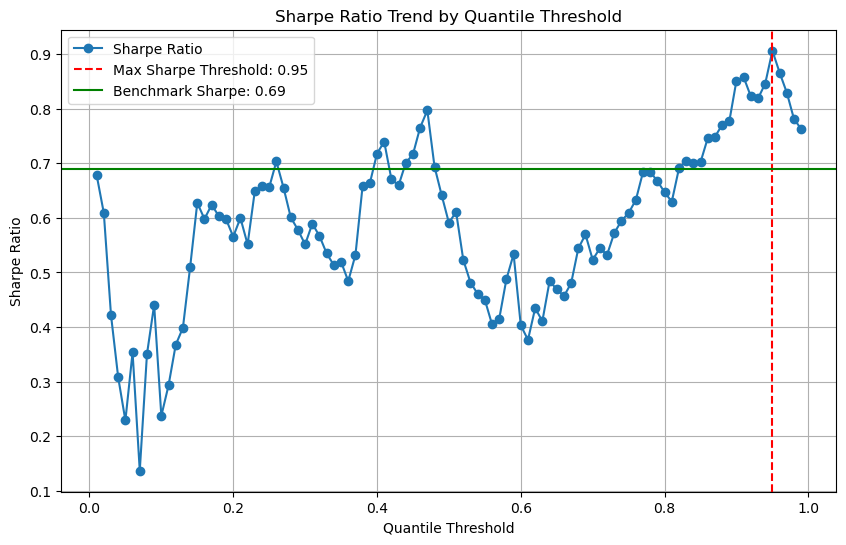

In [725]:


# Threshold별 Sharpe Ratio 추적
thresholds = np.arange(0.01, 1.0, 0.01)
sharpe_ratios = []

for threshold in thresholds:
    temp_df = check_test_df.copy()
    threshold_value = temp_df['transaction_amount_usd'].quantile(threshold)

    # 거래 플래그 생성
    temp_df['transaction_amount_trading_flag'] = temp_df['transaction_amount_usd'].apply(
        lambda x: 1 if x >= threshold_value else (-1 if x < threshold_value else 0)
    )

    # adjusted_returns 생성
    temp_df['adjusted_returns'] = 0
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag'] == -1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day']

    # Sharpe Ratio 계산
    sharpe_ratio = calculate_sharpe_ratio(temp_df['adjusted_returns'])
    sharpe_ratios.append(sharpe_ratio)

# 최적의 threshold 찾기
max_sharpe_ratio = max(sharpe_ratios)
optimal_threshold = thresholds[sharpe_ratios.index(max_sharpe_ratio)]

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', linestyle='-', label='Sharpe Ratio')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Max Sharpe Threshold: {optimal_threshold:.2f}')
plt.axhline(y=benchmark_sharpe, color='green', linestyle='-', label=f'Benchmark Sharpe: {benchmark_sharpe:.2f}')
plt.xlabel('Quantile Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Trend by Quantile Threshold')
plt.grid(True)
plt.legend()

# 고해상도 저장
plt.savefig('sharpe_ratio_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [726]:
# name_list = []
# sharpe_ratio_list = []
# cum_return_list = []
# for i in target_list:
#     # test 데이터 읽기
#     test_df = pd.read_csv("./data/test/test_df.csv")
#     test_df.set_index('date', inplace=True)

#     # target 데이터 읽기
#     target_event_receive_df = pd.read_csv(i)
#     target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
#     target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']
#     target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])



#     ### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
#     # pos, neg, neu, all
#     event_sentiment = 'neg'

#     event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
#     event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

#     if event_sentiment == 'all':
#         pass
#     elif event_sentiment == 'pos':
#         event_df = event_df[event_df['classification']==1]
#     elif event_sentiment == 'neg':
#         event_df = event_df[event_df['classification']==0]
#     elif event_sentiment == 'neu':
#         event_df = event_df[event_df['classification']==2]
#     event_df['classification'] = 1
#     event_df = event_df['classification']
#     event_df = event_df[~event_df.index.duplicated(keep='first')]

#     test_df['event_flag'] = event_df
#     test_df['event_flag'] = test_df['event_flag'].fillna(0)

#     ### 분석 데이터 선택
#     target_df = target_event_receive_df.copy().set_index('date')

#     ### test_df에 target_df 데이터 적용
#     test_df['transaction_count'] = target_df['transaction_count']
#     test_df['transaction_amount'] = target_df['transaction_amount']
#     test_df['transaction_flag'] = target_df['transaction_flag']
#     test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

#     ### test_df의 target 선택
#     test_df['target'] = test_df['transaction_amount_usd']
#     test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

#     ### target 관련 파생변수 생성
#     test_df['target_delta'] = test_df['target'].diff(1)
#     test_df['target_returns'] = test_df['target'].pct_change(1)

#     ### VPIN 관련 변수 추가
#     vpin = pd.read_csv('./data/vpin/vpin.csv')
#     vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
#     vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
#     vpin = vpin.set_index('date')

#     test_df['vpin'] = vpin['vpin']
#     test_df['vpin_ma_10'] = vpin['ma_10']


#     ##### 전처리 관련
#     test_df = test_df.replace([np.inf, -np.inf], np.nan)
#     test_df = test_df.fillna(test_df.mean())


#     # check test df 날짜 인덱싱
#     check_test_df = test_df.copy()
#     check_test_df = check_test_df[check_test_df.index>='2017-01-01']

#     ### test_df에 target_df 데이터 적용
#     check_test_df['transaction_count'] = target_df['transaction_count']
#     check_test_df['transaction_amount'] = target_df['transaction_amount']
#     check_test_df['transaction_flag'] = target_df['transaction_flag']
#     check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']

#     # trading flag 생성
#     check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).shift(-1).fillna(check_test_df.mean())

#     # threshold = 0.1
#     # # 거래량 상위 5% 임계값 설정
#     # upper_threshold = check_test_df['transaction_amount'].quantile(1-threshold)
#     # lower_threshold = check_test_df['transaction_amount'].quantile(threshold)
#     # check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount'].apply(lambda x: 1 if x >= upper_threshold else (-1 if x <= lower_threshold else (-1 if x == np.inf else 0)))

#     threshold = check_test_df['transaction_amount_usd'].quantile(0.97)
#     check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_usd'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

#     # 지연 수익률 계산, carrying 수익률 
#     check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
#     check_test_df['returns_after_1day'] = check_test_df['returns'].shift(-1).fillna(check_test_df.mean())
#     check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
#     check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
#     check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
#     check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

#     ## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
#     check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
#     check_test_df = check_test_df.fillna(check_test_df.mean())

#     # Trading 결과 확인하기 위해 adjusted_returns 생성
#     check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

#     trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
#     check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

#     sharpe_ratio_list.append(check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
#     cum_return_list.append((check_test_df.adjusted_returns + 1).cumprod()[-1])
#     name_list.append(i[14:])


In [727]:
# find_df = pd.DataFrame([name_list, sharpe_ratio_list, cum_return_list]).T
# find_df.columns = ['name', 'sharpe', 'returns']

In [728]:
# find_df